# Simple MNIST NN from scratch

This code was created by Samson Zhang, you can find the original code here: https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: https://youtu.be/w8yWXqWQYmU

In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [38]:
data = pd.read_csv('./digit-recognizer/train.csv')

In [39]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

train_data = data[1000:m].T
Y_train = train_data[0]
X_train = train_data[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

val_data = data[0:1000].T
Y_val = val_data[0]
X_val = val_data[1:n]
X_val = X_val / 255.

In [40]:
Y_train

array([4, 0, 8, ..., 8, 0, 3])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [41]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [42]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [43]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[3 2 3 ... 0 2 7] [4 0 8 ... 8 0 3]
0.10368292682926829
Iteration:  10
[3 3 5 ... 1 5 7] [4 0 8 ... 8 0 3]
0.1583170731707317
Iteration:  20
[2 0 5 ... 1 5 2] [4 0 8 ... 8 0 3]
0.26582926829268294
Iteration:  30
[2 0 5 ... 1 0 2] [4 0 8 ... 8 0 3]
0.3257317073170732
Iteration:  40
[2 0 1 ... 1 0 2] [4 0 8 ... 8 0 3]
0.3651463414634146
Iteration:  50
[7 0 1 ... 1 0 2] [4 0 8 ... 8 0 3]
0.3991219512195122
Iteration:  60
[7 0 1 ... 1 0 2] [4 0 8 ... 8 0 3]
0.43053658536585365
Iteration:  70
[7 0 1 ... 1 0 2] [4 0 8 ... 8 0 3]
0.4538048780487805
Iteration:  80
[7 0 1 ... 1 0 2] [4 0 8 ... 8 0 3]
0.4751951219512195
Iteration:  90
[9 0 1 ... 1 0 2] [4 0 8 ... 8 0 3]
0.4958780487804878
Iteration:  100
[9 0 8 ... 1 0 2] [4 0 8 ... 8 0 3]
0.513
Iteration:  110
[9 0 8 ... 1 0 2] [4 0 8 ... 8 0 3]
0.5300975609756098
Iteration:  120
[9 0 8 ... 1 0 2] [4 0 8 ... 8 0 3]
0.5466341463414635
Iteration:  130
[9 0 8 ... 1 0 2] [4 0 8 ... 8 0 3]
0.5635121951219512
Iteration:  140
[9 0 8 ... 

~85% accuracy on training set.

In [44]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [4]
Label:  4


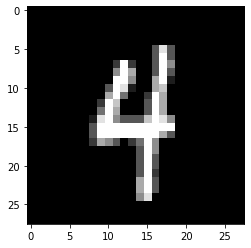

Prediction:  [0]
Label:  0


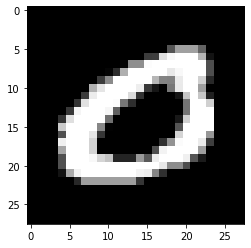

Prediction:  [8]
Label:  8


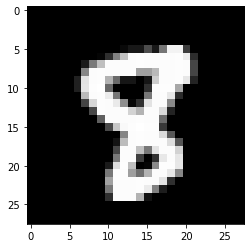

Prediction:  [3]
Label:  3


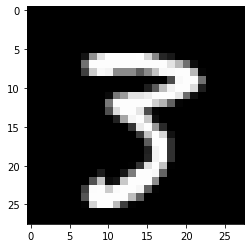

In [45]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the val set:

In [46]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

[6 2 2 8 4 4 8 4 6 9 7 9 9 1 9 7 8 0 4 7 0 4 9 5 6 9 1 1 2 3 2 6 7 6 9 6 0
 7 8 8 6 6 7 9 5 6 4 6 7 0 7 9 2 7 0 0 7 1 1 8 5 3 1 8 0 5 7 3 4 3 9 0 5 9
 4 6 9 6 1 7 4 1 6 3 6 0 3 2 9 9 1 3 1 0 8 5 6 8 5 0 1 1 1 6 4 3 2 7 2 0 6
 6 8 8 3 6 9 1 7 0 2 0 1 7 0 4 8 1 0 1 4 6 7 7 4 2 2 9 3 0 4 9 0 3 2 9 4 0
 6 1 9 7 4 2 2 0 2 5 8 4 8 6 6 2 3 0 6 6 1 2 2 7 2 6 2 6 3 0 1 4 3 2 6 3 5
 7 9 2 6 1 0 9 2 1 7 3 8 9 1 5 6 7 9 6 4 8 9 7 8 3 6 9 2 5 2 8 7 8 8 6 2 8
 7 3 9 5 3 4 9 9 8 3 4 9 1 3 6 6 2 0 2 5 9 0 3 3 2 3 5 9 1 4 2 5 0 1 4 9 0
 9 8 2 1 3 9 2 8 2 9 3 5 6 8 1 3 3 0 3 2 9 7 9 0 2 6 0 6 0 8 6 4 7 1 2 1 2
 6 4 6 9 5 2 3 3 9 7 4 7 8 6 0 9 2 7 9 0 2 8 8 9 9 6 2 1 3 9 2 2 8 7 9 2 2
 1 4 2 3 7 3 8 9 2 9 8 5 4 7 8 7 0 4 4 2 5 7 7 4 1 0 7 1 9 1 9 0 3 5 8 1 9
 5 8 2 3 1 8 3 5 7 7 5 1 8 5 6 6 0 7 1 9 5 5 0 8 1 4 2 5 7 9 4 2 2 8 8 2 9
 7 9 6 1 9 2 7 3 0 2 5 0 2 4 1 1 2 0 4 6 9 8 3 9 1 3 7 0 3 7 1 0 3 4 8 0 3
 5 1 6 0 8 0 3 1 2 6 1 7 9 7 9 4 7 7 7 2 5 8 9 9 7 1 1 1 4 1 4 1 7 3 1 9 1
 0 1 1 0 2 6 6 3 9 7 3 4 

0.856

Still 84% accuracy, so our model generalized from the training data pretty well.